In [1]:
import sys
import os

sys.path.append('../src')

In [2]:
import argparse
import torch
import pytorch_warmup as warmup
import wandb
from tqdm import tqdm
import yaml
import sys
import os
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

from mamba_ssm.models.config_mamba import MambaConfig

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model

from utils import print_model_size, fix_seed
from models.MambaWithEmbeddings import MambaLMHeadModelWithEmbeddings
from training_functions import add_special_token, inference

/home/aleksei_vlasov/miniconda3/envs/mamba_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from data.InductionHeads import ICLDataModule

In [4]:
def get_loader(input_length, vary_length=False):
    module = ICLDataModule(
        num_examples=1,
        num_test_examples=4000,
        vocab_size=16,
        input_seq_len=input_length,
        copy_method='induction_head',
        # Default parameters
        number_duplicates_per_epoch=0,
        seed=42,
        split_train_test=False,
        induction_len=1,
        induction_num_triggers=1,
        allow_dot=False,
        max_copy_len=10,
        test_seq_len=None,
        num_keys=1,
        data_dir=None,
        vary_length=vary_length
    )
    
    module.setup()
    
    # dataloaders
    test_dataloader = module.val_dataloader(batch_size=16)
    return test_dataloader

In [5]:
loader = get_loader(16, vary_length=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 11986.73it/s]


In [6]:
for batch in loader:
    print(batch)
    print(type(batch[0]))
    print(type(batch[1]))
    break

[tensor([[10, 11,  8, 14,  9,  9,  1, 11,  5, 11, 15,  1,  6, 13,  2, 11, 15],
        [ 3,  1,  2,  8, 14,  1,  9,  3,  2,  9, 15, 11,  6,  2, 11, 10, 15],
        [ 8, 11,  1, 13, 12,  1,  1,  9,  5,  7, 15,  9, 11, 12,  9,  2, 15],
        [13, 11,  6,  7,  2, 12, 15,  5,  5,  4,  3, 14, 11,  7,  2,  2, 15],
        [12,  2,  5,  2,  5,  9,  2,  7, 15, 12, 10, 10, 12,  2, 14,  1, 15],
        [14,  8, 14,  4,  8, 13,  7,  4, 12,  6, 15, 14,  3,  5,  1,  6, 15],
        [ 1,  6,  6,  2, 15,  2, 12,  6,  3,  9, 13, 14, 13, 13,  5,  8, 15],
        [12, 10, 13,  4, 10, 13,  5, 12, 14, 15,  3,  4, 10, 13,  1,  5, 15],
        [ 4,  9, 11,  7,  9, 13,  2,  7, 13,  6, 13, 15,  6, 14,  3,  5, 15],
        [ 5,  1,  5,  8, 14,  3,  1, 15,  9,  9,  5,  1, 13,  8, 11,  6, 15],
        [ 1,  1,  1, 11, 12, 12,  8,  6, 15, 11, 12, 14, 14, 10,  3, 14, 15],
        [14,  6, 11, 11, 15, 13, 11, 13,  6, 12,  5, 14,  1,  9,  2, 11, 15],
        [ 8,  2,  9,  8,  1, 13, 10,  1, 14,  3,  1,  6, 15,  8

In [7]:
gpu_number = 4
device = torch.device(f'cuda:{gpu_number}' if torch.cuda.is_available() else 'cpu')

In [8]:
model = torch.load(f'../models/mamba_16.pth', weights_only=False).to(device)

In [13]:
num_tokens = 10
period = 40

In [14]:
special_period = torch.load(f'../models/period_{num_tokens}.pth', weights_only=False).to(device)
special_prefix = torch.load(f'../models/prefix_{num_tokens}.pth', weights_only=False).to(device)

criterion = nn.CrossEntropyLoss()

In [15]:
input_lengths = []
accuracy_periods = []
accuracy_prefixes = []

for input_length in [64, 128, 256, 512, 1024, 2048, 4096]:
    test_dataloader = get_loader(input_length, vary_length=False)

    test_loss, test_accuracy_period = inference(
        model, test_dataloader, device, criterion=criterion, num_last_tokens=1, special_token=special_period, period=period, log=False
    )

    test_loss, test_accuracy_prefix = inference(
        model, test_dataloader, device, criterion=criterion, num_last_tokens=1, special_token=special_prefix, period=-1, log=False
    )

    input_lengths.append(input_length)
    accuracy_periods.append(test_accuracy_period)
    accuracy_prefixes.append(test_accuracy_prefix)

Inference: 100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 326.50it/s, Loss (batch)=6.3]


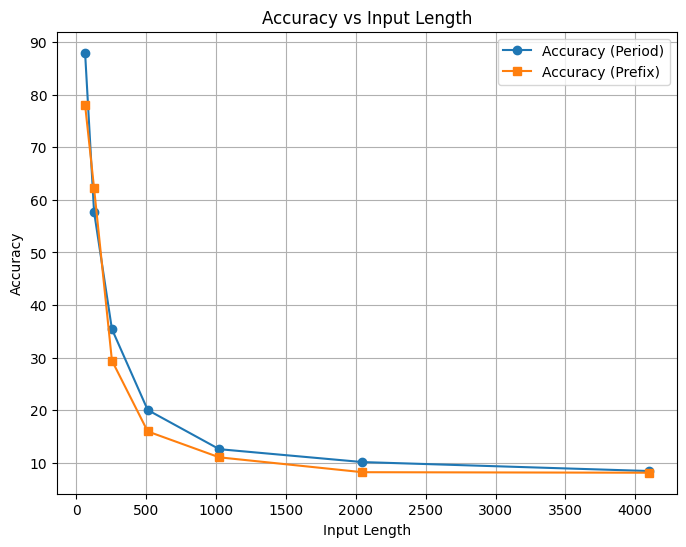

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(input_lengths, accuracy_periods, marker='o', label='Accuracy (Period)')
plt.plot(input_lengths, accuracy_prefixes, marker='s', label='Accuracy (Prefix)')
plt.xlabel('Input Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Input Length')
plt.legend()
plt.grid(True)
plt.show()